In [15]:
from dotenv import load_dotenv
load_dotenv()

True

In [26]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

In [19]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

In [27]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/ceme_example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [28]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [29]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI

class State(MessagesState):
    summary: str
def call_model(state: State):
    summary = state.get("summary", "")

    if summary:
        system_message = f"Previous conversation summary: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"Current summary: {summary}\n\n"
            "Update this summary with the new messages above:"
        )
    else:
        summary_message = "Create a brief summary of this conversation:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State):
    messages = state["messages"]

    if len(messages) > 4:
        return "summarize_conversation"

    return END


In [30]:
# Build the graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Add memory to persist conversations
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)


In [31]:
# Create a thread
config = {"configurable": {"thread_id": "tech-support-1"}}

# Start conversation
input_message = HumanMessage(content="Hi, I'm having issues with my laptop")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="It's running very slow")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I have 8GB RAM and Windows 10")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Yes, I've tried restarting it")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

I'm sorry to hear that you're having issues with your laptop. Could you provide more details about the problem you're experiencing? This will help me assist you better.
================================== Ai Message ==================================

A slow laptop can be frustrating, but there are several steps you can take to try to improve its performance. Here are some common solutions:

1. **Restart Your Laptop**: Sometimes, a simple restart can resolve temporary issues and improve performance.

2. **Check for Malware**: Run a full system scan using your antivirus software to check for malware or viruses that could be slowing down your laptop.

3. **Close Unnecessary Programs**: Open the Task Manager (Ctrl + Shift + Esc on Windows or Activity Monitor on macOS) to see which programs are using the most resources. Close any that you don't need running.

4. **Disable Startup Programs**: Too many programs 

In [32]:
summary = graph.get_state(config).values.get("summary", "")
print(summary)

The user is experiencing slowness with their Windows 10 laptop, which has 8GB of RAM. I provided several troubleshooting steps to improve performance, including restarting the laptop, checking for malware, closing unnecessary programs, disabling startup programs, freeing up disk space, updating the operating system and drivers, adjusting visual effects, and optimizing the hard drive. I also suggested running performance troubleshooters, checking for disk errors, increasing virtual memory, and considering a clean boot. If these steps don't help, a hardware upgrade might be necessary.


In [33]:
input_message = HumanMessage(content="What should I check next?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

If you've already tried restarting and are still experiencing slowness, here are some specific areas to check next:

1. **Task Manager for Resource Usage**:
   - Open Task Manager by pressing `Ctrl + Shift + Esc`.
   - Check the "Processes" tab to see which applications are using the most CPU, memory, and disk resources. If you notice any programs consuming excessive resources, consider closing them or uninstalling if they're not needed.

2. **Windows Updates**:
   - Ensure your system is up to date. Go to Settings > Update & Security > Windows Update and check for updates. Install any pending updates.

3. **Malware Scan**:
   - Run a full system scan using Windows Defender or another trusted antivirus program to rule out malware as a cause of the slowdown.

4. **Startup Programs**:
   - In Task Manager, go to the "Startup" tab and disable any unnecessary programs that start with Windows. This can help sp

In [34]:
summary = graph.get_state(config).values.get("summary", "")
print(summary)

The user is experiencing slowness with their Windows 10 laptop, which has 8GB of RAM. They have already tried restarting the laptop. I provided several troubleshooting steps to improve performance, including checking for malware, managing startup programs, freeing up disk space using Disk Cleanup, updating the operating system and drivers, adjusting visual effects, and optimizing power settings. I also suggested using Task Manager to identify resource-heavy applications, running performance troubleshooters, checking for disk errors with `chkdsk`, increasing virtual memory, and performing a clean boot to identify problematic background programs. If these steps don't resolve the issue, a hardware upgrade, such as adding more RAM or switching to an SSD, might be necessary.


Confirming if our thread is saved locally

In [36]:
config = {"configurable": {"thread_id": "tech-support-1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='What should I check next?', additional_kwargs={}, response_metadata={}, id='2b537f56-c084-4f73-8e66-08b5c5ea86c5'), AIMessage(content='If you\'ve already tried restarting and are still experiencing slowness, here are some specific areas to check next:\n\n1. **Task Manager for Resource Usage**:\n   - Open Task Manager by pressing `Ctrl + Shift + Esc`.\n   - Check the "Processes" tab to see which applications are using the most CPU, memory, and disk resources. If you notice any programs consuming excessive resources, consider closing them or uninstalling if they\'re not needed.\n\n2. **Windows Updates**:\n   - Ensure your system is up to date. Go to Settings > Update & Security > Windows Update and check for updates. Install any pending updates.\n\n3. **Malware Scan**:\n   - Run a full system scan using Windows Defender or another trusted antivirus program to rule out malware as a cause of the slowdown.\n\n4. **Startup Programs**:\

### LANGGRAPH STUDIO

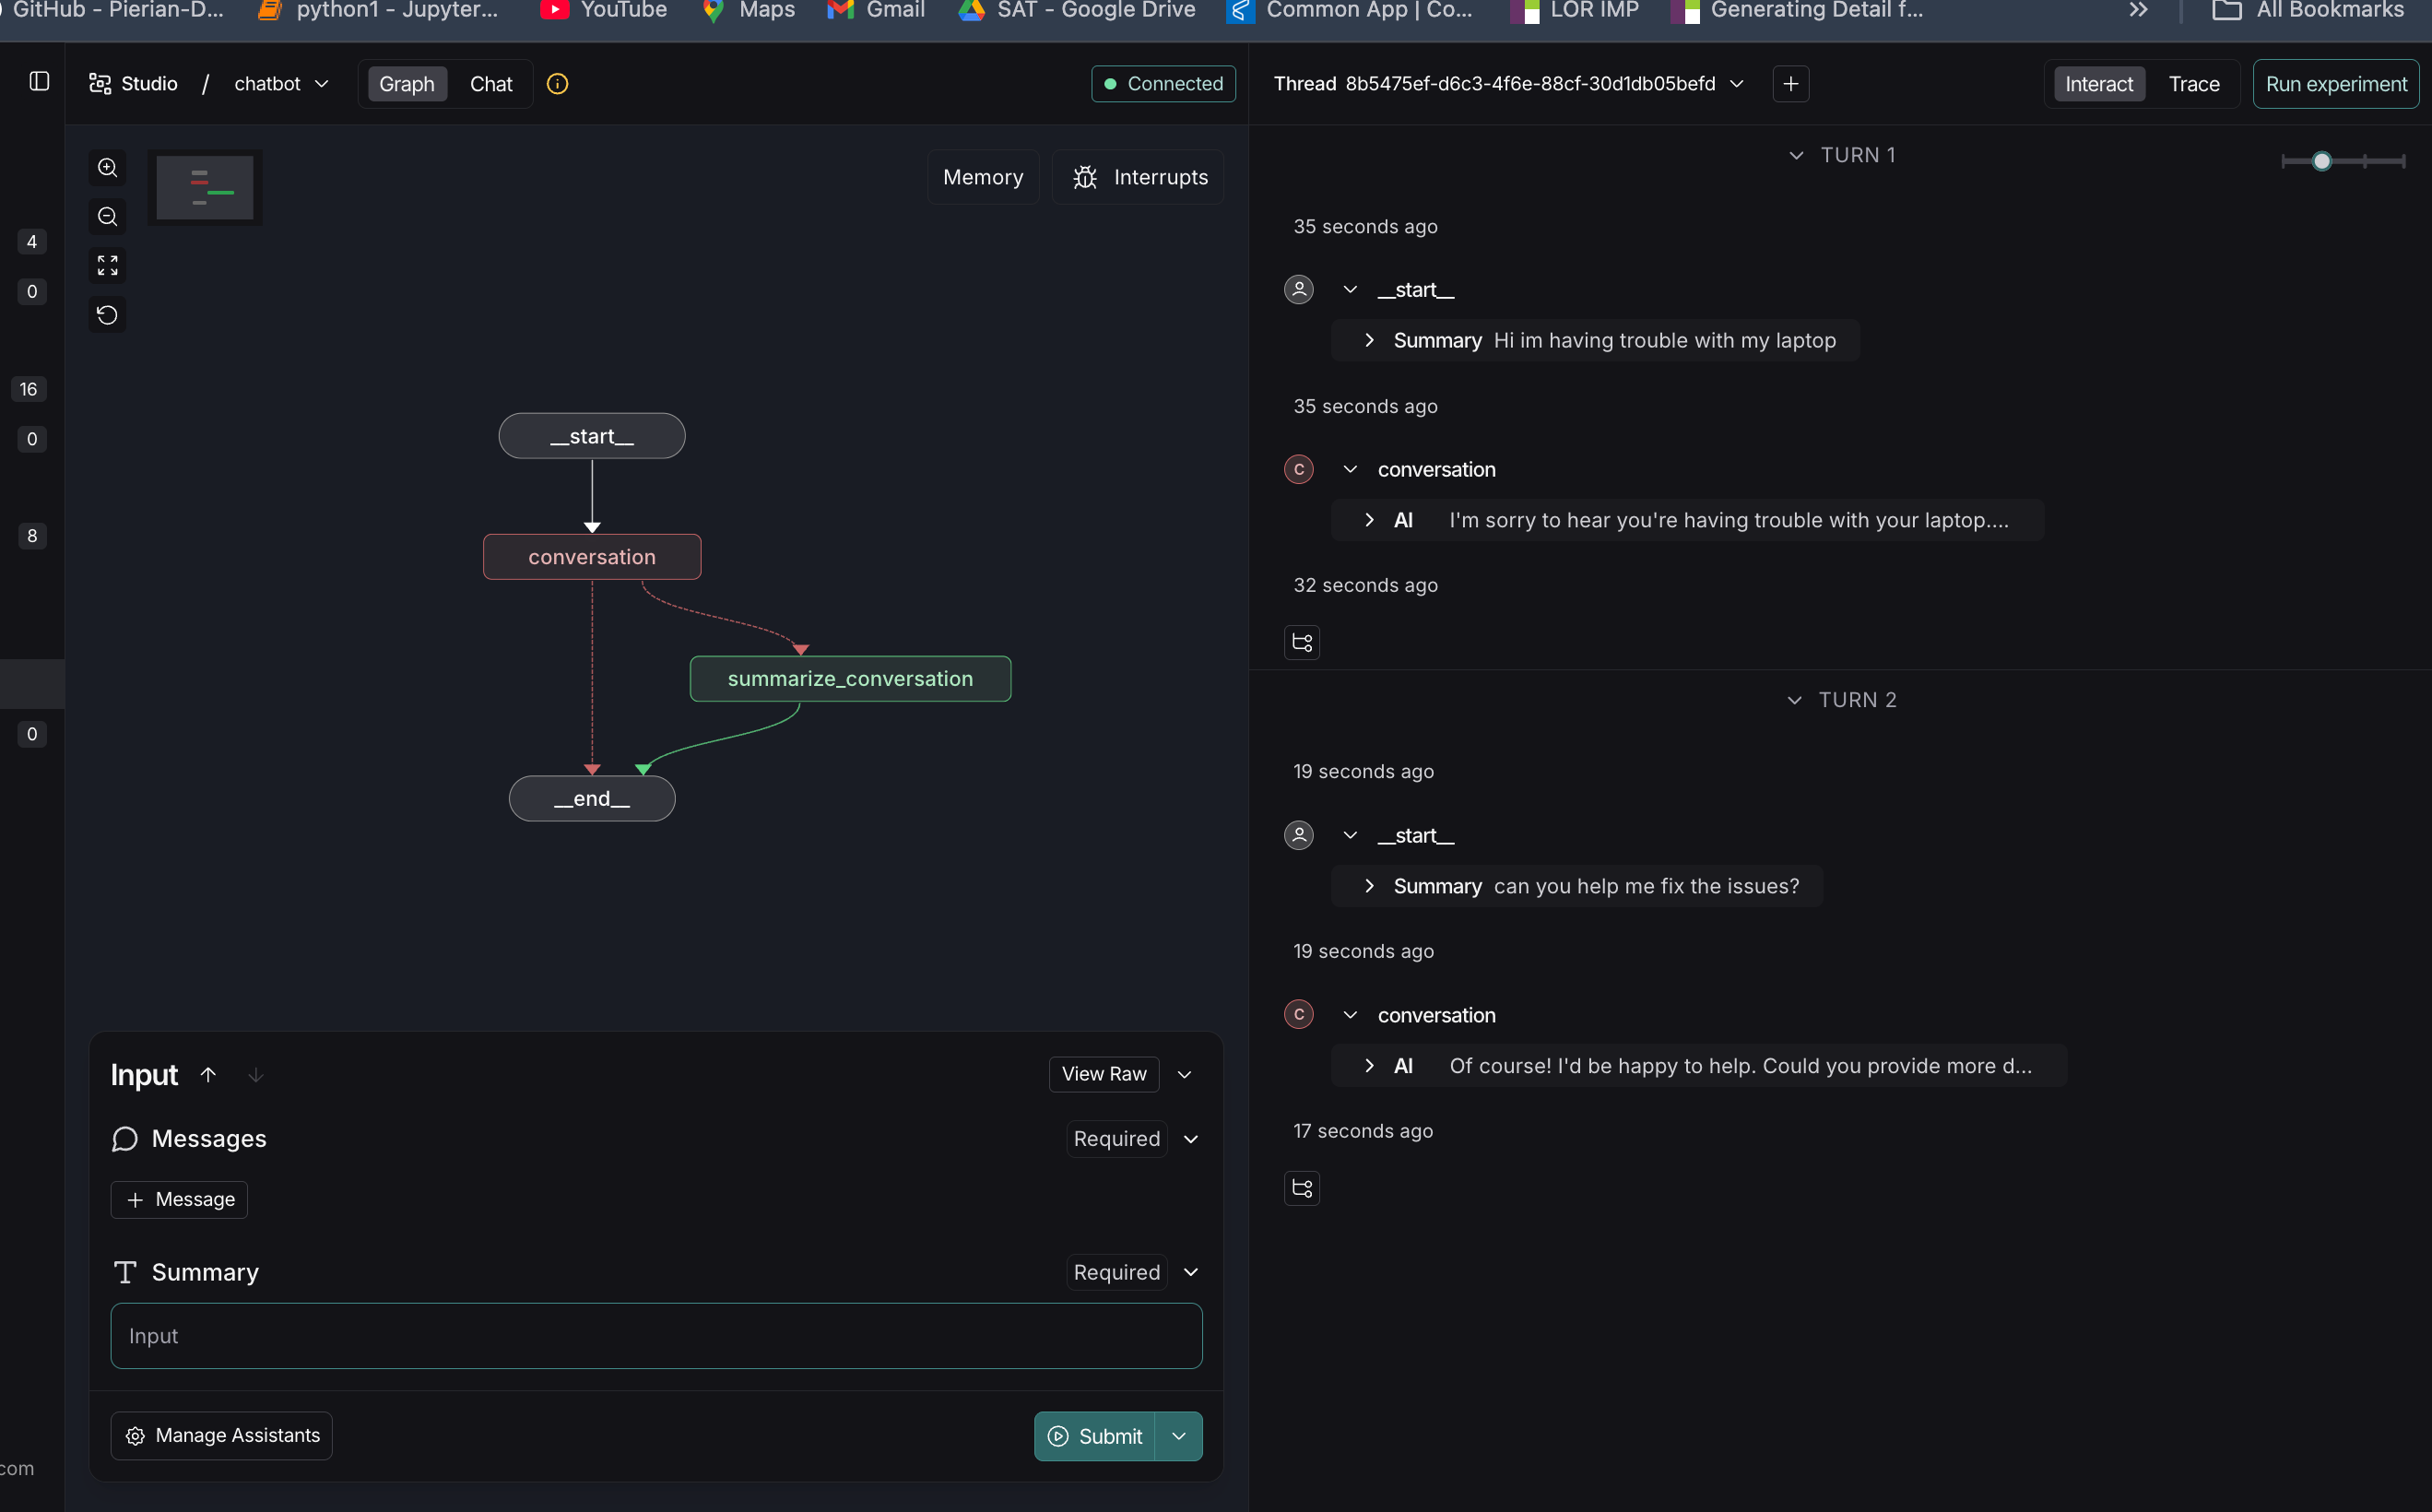

chatbot when the number of messages exceeds 4

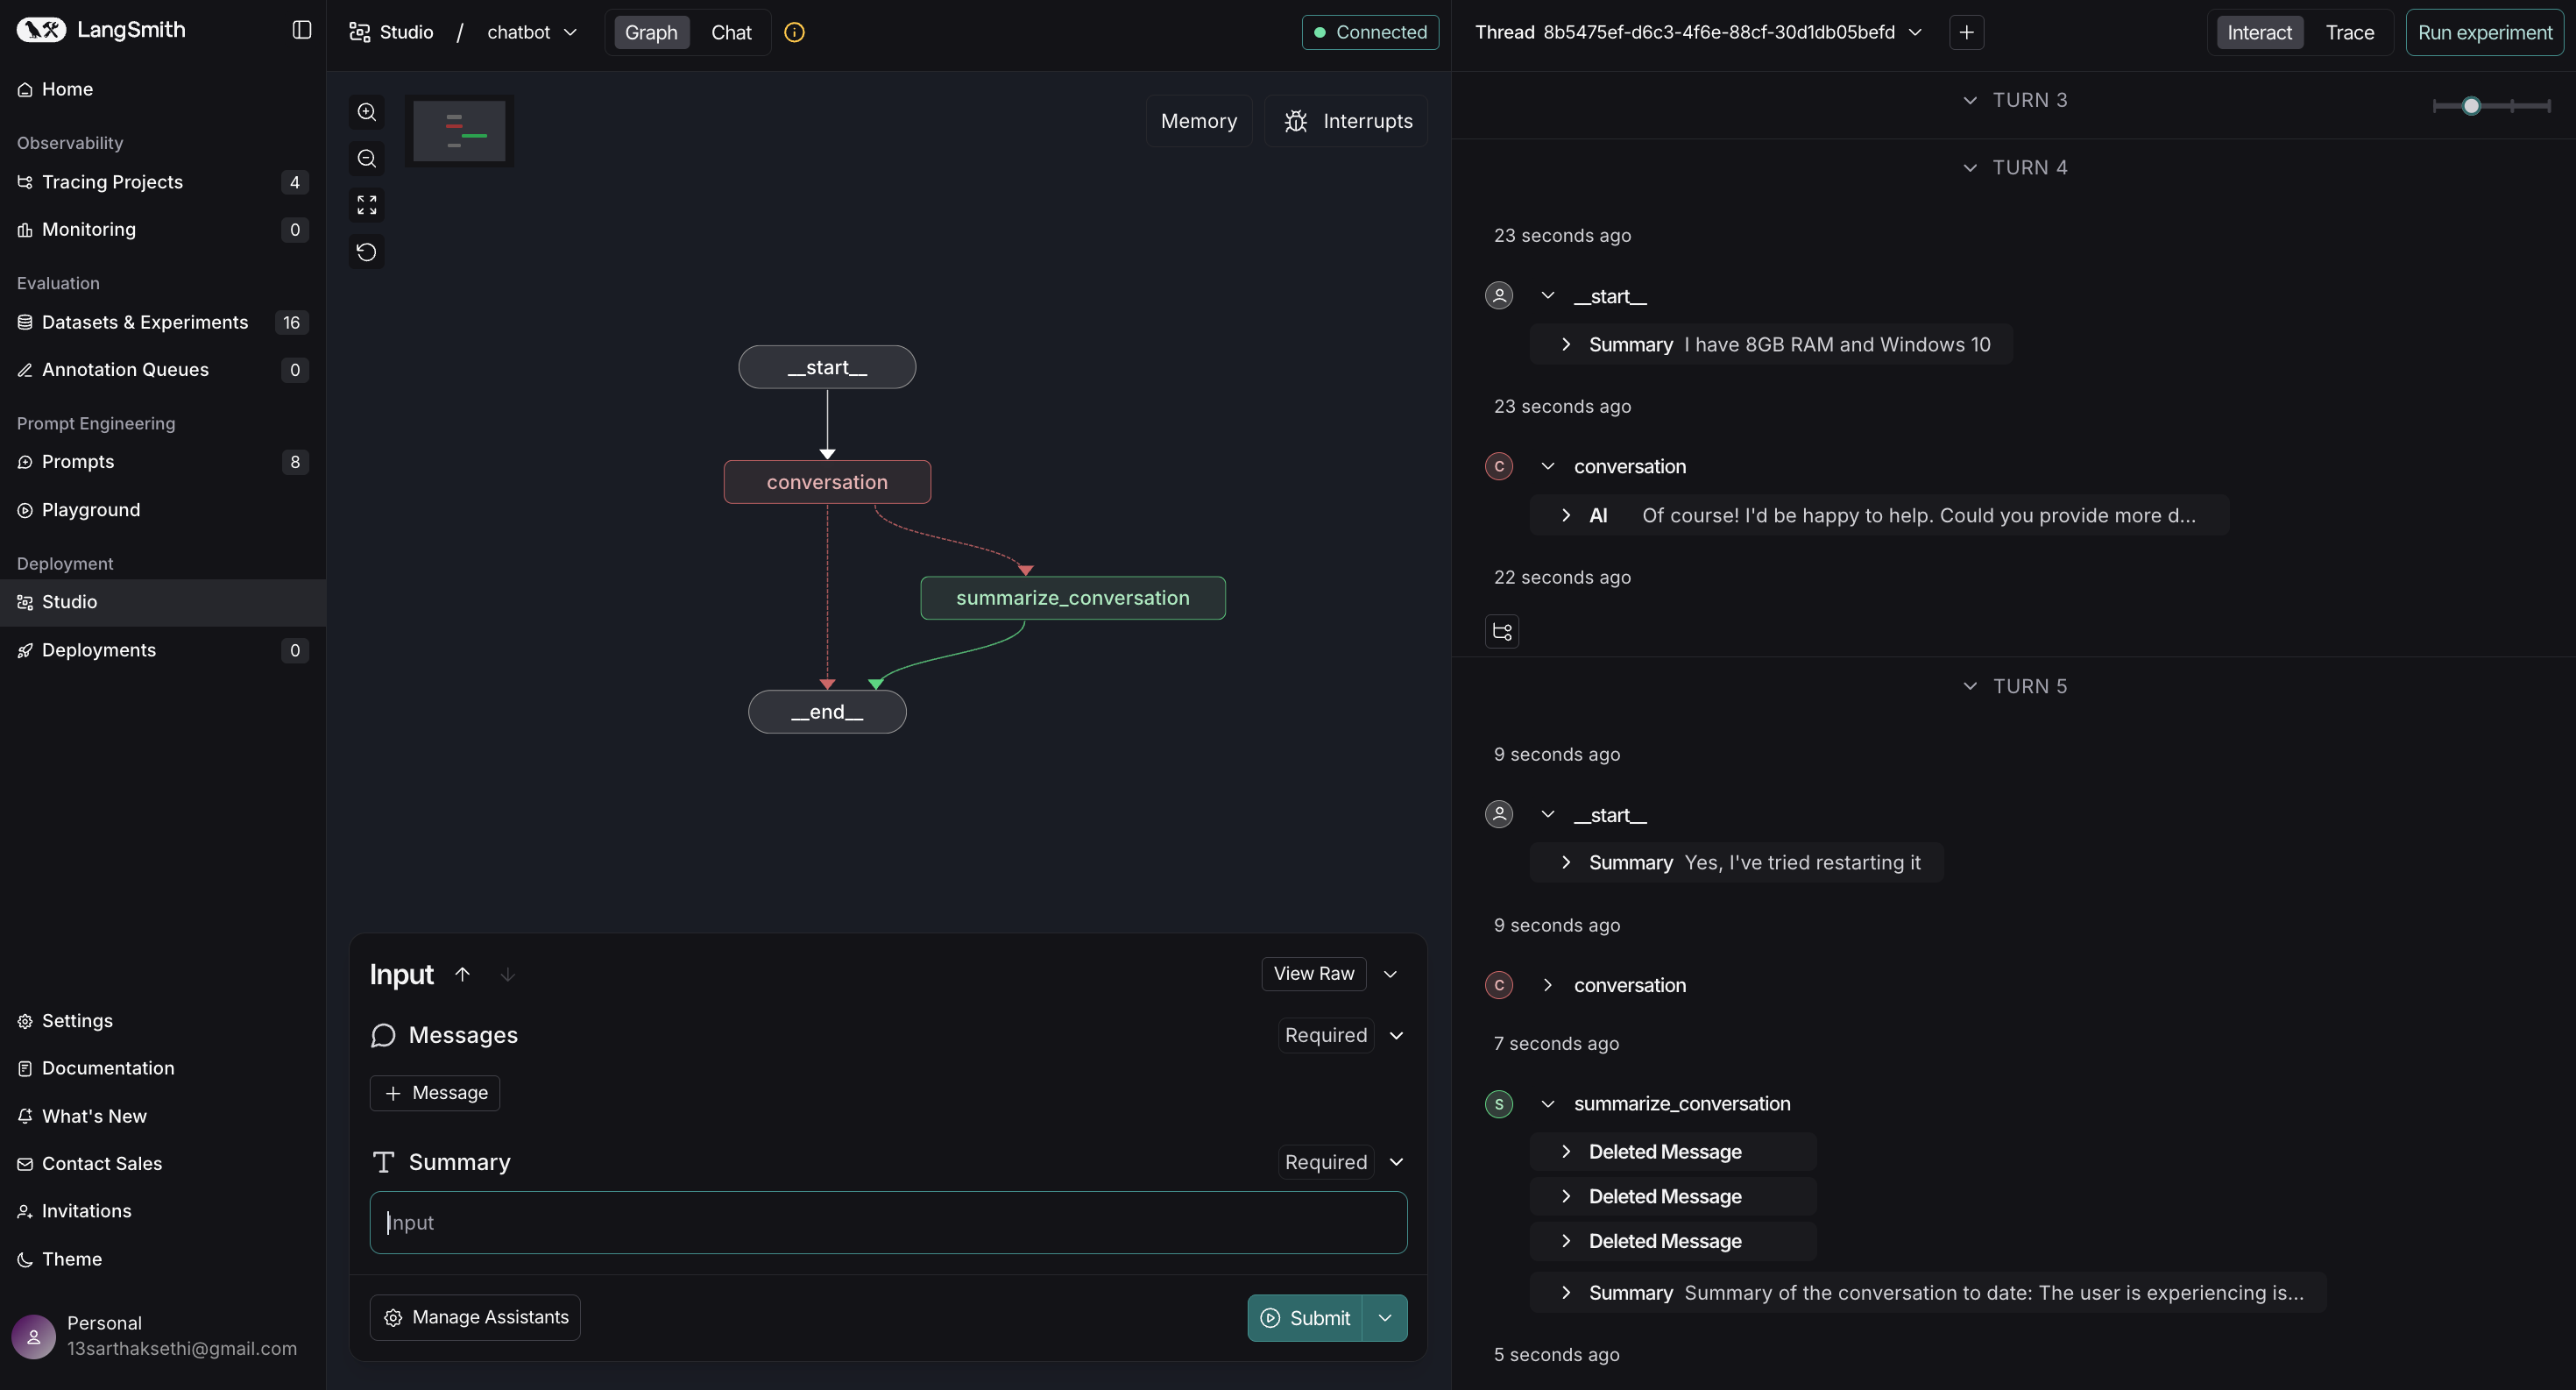